# Tutorial #1: Analysis of PCNs

We see how to analyse a PCN, studying its behaviour with respect to gradient updates.
The code is an adaptation from tutorial #0. In particular, the code defining the model is unchanged, and only the training functions are expanded to include the analysis part.

In [1]:
# Install dependencies not included in the base requirements.txt

!pip install scikit-learn matplotlib

/bin/bash: /share/amine.mcharrak/miniconda3/envs/pcax24/bin/pip: /home/amine.mcharrak/miniconda3/envs/pcax24/bin/python: bad interpreter: No such file or directory


In [2]:
from typing import Callable

import jax
import jax.tree_util as jtu
import jax.numpy as jnp
jax.clear_backends()  # Clear any existing JAX backends
import equinox as eqx

import pcx as px
import pcx.predictive_coding as pxc
import pcx.nn as pxnn
import pcx.functional as pxf
import pcx.utils as pxu

/tmp/ipykernel_4143450/1556283075.py:6: DeprecationWarning: jax.clear_backends is deprecated.
  jax.clear_backends()  # Clear any existing JAX backends


In [3]:
class Model(pxc.EnergyModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        nm_layers: int,
        act_fn: Callable[[jax.Array], jax.Array]
    ) -> None:
        super().__init__()

        self.act_fn = px.static(act_fn)
        
        self.layers = [pxnn.Linear(input_dim, hidden_dim)] + [
            pxnn.Linear(hidden_dim, hidden_dim) for _ in range(nm_layers - 2)
        ] + [pxnn.Linear(hidden_dim, output_dim)]

        self.vodes = [
            pxc.Vode() for _ in range(nm_layers - 1)
        ] + [pxc.Vode(pxc.ce_energy)]
        
        self.vodes[-1].h.frozen = True

    def __call__(self, x, y):
        for v, l in zip(self.vodes[:-1], self.layers[:-1]):
            x = v(self.act_fn(l(x)))

        x = self.vodes[-1](self.layers[-1](x))

        if y is not None:
            self.vodes[-1].set("h", y)

        return self.vodes[-1].get("u")

In [4]:
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0, 0), out_axes=0)
def forward(x, y, *, model: Model):
    return model(x, y)

@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0,), out_axes=(None, 0), axis_name="batch")
def energy(x, *, model: Model):
    y_ = model(x, None)
    return jax.lax.psum(model.energy(), "batch"), y_

In [5]:
@pxf.jit(static_argnums=0)
def train_on_batch(
    T: int,
    x: jax.Array,
    y: jax.Array,
    *,
    model: Model,
    optim_w: pxu.Optim,
    optim_h: pxu.Optim
):
    model.train()

    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)

    for i in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, y_), g = pxf.value_and_grad(
                pxu.M_hasnot(pxc.VodeParam, frozen=True).to([False, True]),
                has_aux=True
            )(energy)(x, model=model)
        
        optim_h.step(model, g["model"])

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        (e, y_), g = pxf.value_and_grad(pxu.M(pxnn.LayerParam).to([False, True]), has_aux=True)(energy)(x, model=model)
    optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])

In [6]:
import numpy as np


@pxf.jit()
def eval_on_batch(x: jax.Array, y: jax.Array, *, model: Model):
    model.eval()
    
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        y_ = forward(x, None, model=model).argmax(axis=-1)
    
    return (y_ == y).mean(), y_


def train(dl, T, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    for x, y in dl:
        train_on_batch(T, x, jax.nn.one_hot(y, 2), model=model, optim_w=optim_w, optim_h=optim_h)


def eval(dl, *, model: Model):
    acc = []
    ys_ = []
    
    for x, y in dl:
        a, y_ = eval_on_batch(x, y, model=model)
        acc.append(a)
        ys_.append(y_)
    
    return np.mean(acc), np.concatenate(ys_)

In [7]:
import optax


batch_size = 64
nm_layers = 4


# we merge initialisation in a single function to be able to create multiple models.
def init(
    batch_size: int,
    hidden_dim: int,
    h_lr: float = 1e-2,
    nm_layers: int = 4,
    act_fn: Callable[[jax.Array], jax.Array] = jax.nn.leaky_relu
):
    model = Model(
        input_dim=2,
        hidden_dim=hidden_dim,
        output_dim=2,
        nm_layers=nm_layers,
        act_fn=act_fn
    )
    
    # here, we use a state optimizer without internal state (i.e., no momentum), so we
    # initialise it once without the need to init/clear it for every batch.
    # we also perform a dummy forward pass so to initialise the `Vodes` before the first
    # `train_on_batch` call to avoid recompilation.
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(jax.numpy.zeros((batch_size, 2)), None, model=model)
        
        optim_h = pxu.Optim(lambda: optax.sgd(h_lr), pxu.M_hasnot(pxc.VodeParam, frozen=True)(model))
        optim_w = pxu.Optim(lambda: optax.adamw(1e-2), pxu.M(pxnn.LayerParam)(model))
    
    return model, optim_h, optim_w

In [8]:
from sklearn.datasets import make_moons

nm_elements = 512
X, y = make_moons(n_samples=batch_size * (nm_elements // batch_size), noise=0.2, random_state=42)

In [9]:
train_dl = list(zip(X.reshape(-1, batch_size, 2), y.reshape(-1, batch_size)))

X_test, y_test = make_moons(n_samples=batch_size * (nm_elements // batch_size) // 2, noise=0.2, random_state=0)
test_dl = tuple(zip(X_test.reshape(-1, batch_size, 2), y_test.reshape(-1, batch_size)))

### Analysis

Instead of training a single PCN, we iterate over several hidden widths and for each resulting network we compute the best h learning rate.
Note that we do not change the number of layers (set to 4) or the number of inference steps (set to 8).

Ideally hidden width and h learning rate should be independent values, as the h learning rate should only affect how the error propagates through multiple layers, and be uneffected by the properties of each single layer (also because this would make networks with layers of different sizes inheritely difficult to train).

In [10]:
import random

nm_epochs = 32 // (nm_elements // batch_size)

# We test over the following values
h_dims = [16, 32, 64, 128, 256, 512, 1024, 2048]
h_lrs = [1e-3, 3e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 3e-1, 5e-1]

def run(
    nm_epochs,
    model,
    optim_h,
    optim_w,
    train_dl,
    test_dl,
    T = 8
):
    for _ in range(nm_epochs):
        random.shuffle(train_dl)
        train(train_dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
    a, _ = eval(test_dl, model=model)
    
    return a

In [11]:
acc_by_dim = {}

for h_dim in h_dims:
    acc_by_dim[h_dim] = []
    for h_lr in h_lrs:
        print(f"Running h_dim={h_dim} and h_lr={h_lr}.", end=" ")
        model, optim_h, optim_w = init(batch_size, h_dim, h_lr, act_fn=jax.nn.leaky_relu)
        a = run(nm_epochs, model, optim_h, optim_w, train_dl, test_dl, 8)
        acc_by_dim[h_dim].append(a)
        print(f"Accuracy: {(a*100.0):.2f}%")

Running h_dim=16 and h_lr=0.001. Accuracy: 88.67%
Running h_dim=16 and h_lr=0.003. Accuracy: 90.62%
Running h_dim=16 and h_lr=0.005. Accuracy: 89.06%
Running h_dim=16 and h_lr=0.01. Accuracy: 88.28%
Running h_dim=16 and h_lr=0.03. Accuracy: 91.02%
Running h_dim=16 and h_lr=0.05. Accuracy: 88.28%
Running h_dim=16 and h_lr=0.1. Accuracy: 89.45%
Running h_dim=16 and h_lr=0.3. Accuracy: 90.23%
Running h_dim=16 and h_lr=0.5. Accuracy: 83.20%
Running h_dim=32 and h_lr=0.001. Accuracy: 92.58%
Running h_dim=32 and h_lr=0.003. Accuracy: 93.36%
Running h_dim=32 and h_lr=0.005. Accuracy: 94.14%
Running h_dim=32 and h_lr=0.01. Accuracy: 93.36%
Running h_dim=32 and h_lr=0.03. Accuracy: 91.80%
Running h_dim=32 and h_lr=0.05. Accuracy: 91.80%
Running h_dim=32 and h_lr=0.1. Accuracy: 92.97%
Running h_dim=32 and h_lr=0.3. Accuracy: 91.80%
Running h_dim=32 and h_lr=0.5. Accuracy: 89.84%
Running h_dim=64 and h_lr=0.001. Accuracy: 92.58%
Running h_dim=64 and h_lr=0.003. Accuracy: 96.88%
Running h_dim=64 a

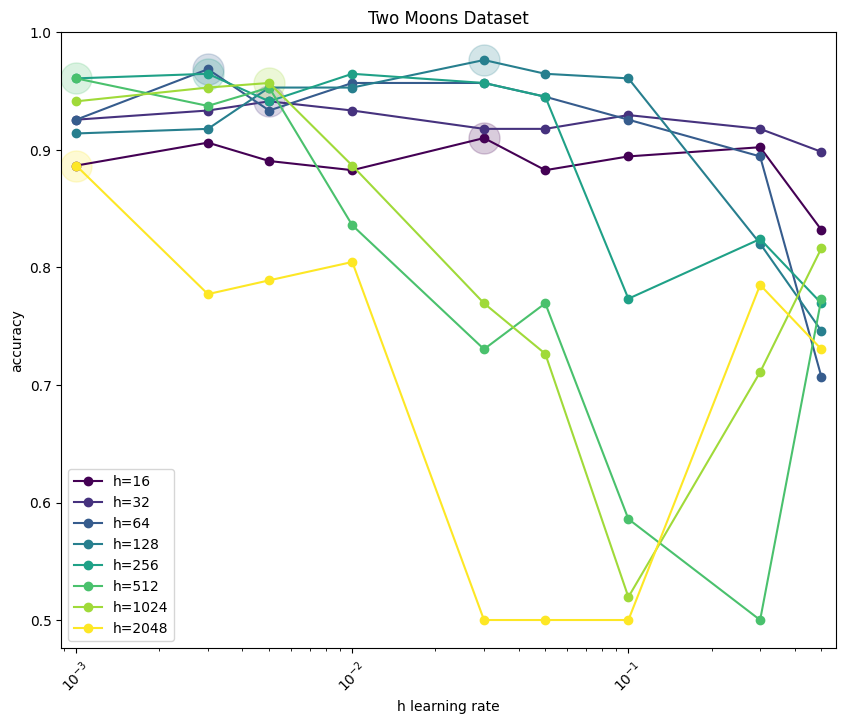

In [12]:
import matplotlib.pyplot as plt


# Plot the dataset
plt.figure(figsize=(10, 8))

for i, (h_dim, accs) in enumerate(acc_by_dim.items()):
    color = plt.get_cmap('viridis')(i / (len(acc_by_dim) - 1))
    plt.plot(h_lrs, accs, marker="o", color=color, label=f"h={h_dim}")
    
    max_acc = max(accs)
    i_max = accs.index(max_acc)
    plt.scatter(h_lrs[i_max], max_acc, s=500, color=color, alpha=0.2)

plt.margins(x = 0.02)
plt.xticks(h_lrs, h_lrs, rotation=45)
plt.xscale("log")
plt.legend()
plt.title("Two Moons Dataset")
plt.xlabel("h learning rate")
plt.ylabel("accuracy")
plt.show()

We can see that our hypothesis is wrong! And the best learning rate changes drastically for different hidden sizes. This is true for different choices of activation function, and even by using a SE energy instead of the standard CE energy (so it is unrelated to it, note that SE energy performs drastically worse than CE, as expected). We chose to use leaky_relu as default activation function to show the most evident correlation (note that based on the seed it not be perfect).

What we see is that high hidden dim values prefer small learning rates and are unstable for larger values. This does not apply to BP, which is unaffected by the width of the network. Something is wrong, could it be the default weight initialisation being not suitable for PC (to this day, we haven't solved this, but we are working on it)?

In "Understanding the difficulty of training deep feedforward neural networks", the authors suggest that the variance of the gradients should be costant through the network, as we want information that doesn't vanish or explode throughout the layers (eqs. 8,9, 14). To measure this, we check the ratio between the gradients of different layers. To do so, we modify the train function to return such information:

In [13]:
@pxf.jit(static_argnums=0)
def train_on_batch_with_ratio(
    T: int,
    x: jax.Array,
    y: jax.Array,
    *,
    model: Model,
    optim_w: pxu.Optim,
    optim_h: pxu.Optim
):
    model.train()

    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)

    for i in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, y_), g = pxf.value_and_grad(
                pxu.M_hasnot(pxc.VodeParam, frozen=True).to([False, True]),
                has_aux=True
            )(energy)(x, model=model)
        
        optim_h.step(model, g["model"])

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        (e, y_), g = pxf.value_and_grad(pxu.M(pxnn.LayerParam).to([False, True]), has_aux=True)(energy)(x, model=model)
    optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])
    
    # We measure the variance of the gradients for the second and third layer
    # Note that by having 4 layers in total we guaranteed that the two layers we compare have the same shape.
    assert g["model"].layers[1].nn.weight.get().shape == g["model"].layers[2].nn.weight.get().shape, "Shapes can't be different"
    var_g_w1 = jnp.var(g["model"].layers[1].nn.weight.get())
    var_g_w2 = jnp.var(g["model"].layers[2].nn.weight.get())
    
    return var_g_w1 / var_g_w2


def train_with_ratio(dl, T, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    ratios = []
    for x, y in dl:
        ratio = train_on_batch_with_ratio(T, x, jax.nn.one_hot(y, 2), model=model, optim_w=optim_w, optim_h=optim_h)
        ratios.append(ratio)
        
    return np.mean(ratios)

def run_with_ratio(
    nm_epochs,
    model,
    optim_h,
    optim_w,
    train_dl,
    test_dl,
    T = 16
):
    for i in range(nm_epochs):
        random.shuffle(train_dl)
        ratio = train_with_ratio(train_dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        print(f"\tAvg. gradient ratio for epoch {i + 1}: {ratio}")
    a, _ = eval(test_dl, model=model)
    
    return a

In [14]:
h_dims = [50, 200, 800, 1600]
# we use a learning rate that works for all the chosen dims.
h_lr = 3e-3

for h_dim in h_dims:
    print(f"Running h_dim={h_dim}")
    model, optim_h, optim_w = init(batch_size, h_dim, h_lr, act_fn=jax.nn.leaky_relu)
    a = run_with_ratio(nm_epochs, model, optim_h, optim_w, train_dl, test_dl, 16)
    print(f"Accuracy: {(a*100.0):.2f}%")

Running h_dim=50
	Avg. gradient ratio for epoch 1: 0.000799648289103061
	Avg. gradient ratio for epoch 2: 0.0012157107703387737
	Avg. gradient ratio for epoch 3: 0.0010175607167184353
	Avg. gradient ratio for epoch 4: 0.001293609500862658
Accuracy: 93.36%
Running h_dim=200
	Avg. gradient ratio for epoch 1: 0.000813695602118969
	Avg. gradient ratio for epoch 2: 0.0009064950281754136
	Avg. gradient ratio for epoch 3: 0.0014940367545932531
	Avg. gradient ratio for epoch 4: 0.0017511548940092325
Accuracy: 95.70%
Running h_dim=800
	Avg. gradient ratio for epoch 1: 0.0006377113168127835
	Avg. gradient ratio for epoch 2: 0.0007382560870610178
	Avg. gradient ratio for epoch 3: 0.002605224261060357
	Avg. gradient ratio for epoch 4: 0.0033812150359153748
Accuracy: 89.45%
Running h_dim=1600
	Avg. gradient ratio for epoch 1: 0.0001221122220158577
	Avg. gradient ratio for epoch 2: 2.0702847905340604e-05
	Avg. gradient ratio for epoch 3: 9.55292307480704e-06
	Avg. gradient ratio for epoch 4: 0.01263

: 

We can see that the ratio is not stable, as it should instead be. Note that by increasing the h learning rate or the number T of inference steps, it can be brought closer to 1 for the smaller architectures. However, larger h learning rates make big architectures unstable, making the difficult to train (as you can only play around with T and increase the total computational cost).